Convolutional Neural Network by Marlo Esperson


Raytheon Advisors: David Detienne and Kerry Courtright

Faculty Advisor: Alex Orange

Team Members: Josh Miraglia, Ryan Procarione, and Erik Graham

Last Update: 5.02.2022 

The purpose of this program is to take in labeled generated signal data (bandwidth, center frequency, and signal-to-noise ratio (SNR)) from a Massive MIMO antenna and use it to train and test a convolutional neural network model that will be able to estimate bandwidth, center frequency, time, and SNR parameters.


Read in all signal data and labels:

In [1]:
#plotting function
%matplotlib notebook

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os


# Anechoic Chamber dataset:
filein = "/mnt/nndataset/experiment1/run1x1/CNN_dataset.hdf5"

with h5py.File(filein, "r") as f:
    folders = f.keys()
    data = f.get('signals/rx_signals') # Pulls received MIMO signals
    
   
    signal_data = data[0] # First signal in received signals
    gen_sigs = np.array(signal_data) # Places first signal into a numpy array.
    
    # Frequency Signal Parameters:
    bandwidth = np.array(f.get('labels/bandwidth')) # Fractional Bandwidth
    centerf = np.array(f.get('labels/center_freq')) # Center Frequency
    SNR = np.array(f.get('labels/SNR')) # Signal-to-Noise Ratio
    SNR_sf = np.max(SNR) 
    #print(SNR_sf)
    SNR = SNR/SNR_sf # Divide by largest SNR value to normalize SNR data to make all parameters similar sizes.
  
    # Time Parameters
    start = np.array(f.get('labels/start_index'))/2048 # Start Time, divided by size of signal to normalize.
    stop = np.array(f.get('labels/end_index'))/2048 # Stop Time, divided by size of signal to normalize.


#### Move bandwidth labeled data into an array:

In [3]:
dataset_fft = abs(np.fft.fftshift(np.fft.fft(gen_sigs), (1,))) # Fourier transform for Frequency parameters. Time -> Freq



# Append transformed Frequency data and untransformed Time data into the same array.
inputdata = np.array([dataset_fft, gen_sigs])
np.shape(inputdata)
inputdata = np.swapaxes(inputdata, 0, 1)
np.shape(inputdata)
inputdata = np.swapaxes(inputdata, 2, 1)


Splitting Dataset into Training and Testing Data

In [4]:
import os
num_threads = 24
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "24"

import tensorflow as tf


tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(24)
tf.config.set_soft_device_placement(True)

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import sys
import h5py
import random
import datetime


# Casts a list indexing from 0 to 29951. 
idx = list(range(len(centerf)))

# Shuffles indices of bandwidth, center freq, SNR, stop time, and start time datasets
# Ramdom seed 3700 was chosen because it was properly shuffling the data.
random.Random(3700).shuffle(idx)


# Splitting datasets: 80% for training and 20% for testing
training_indices, testing_indices = np.split(idx, [int(0.8*len(idx))])


# Initialize training and testing data and label arrays:
training_data = []
training_labels = []
testing_data = []
testing_labels = []


# These loops place the shuffled input data indices and labels into arrays. 
# training_data and training_labels are fed into the CNN to train it, and the testing_data and testing_labels are
# used to verify the network's predictions.

for idx in training_indices:
    #iterate through all indices
    training_data.append(inputdata[idx])
    training_labels.append([start[idx], stop[idx], bandwidth[idx], SNR[idx], centerf[idx]])
    

# Put training_data and training_labels into a numpy array.
training_data = tf.convert_to_tensor(np.array(training_data), dtype=tf.float32)
training_labels = tf.convert_to_tensor(np.array(training_labels), dtype=tf.float32)

   
for idx in testing_indices:
    testing_data.append(inputdata[idx])
    testing_labels.append([start[idx], stop[idx], bandwidth[idx], SNR[idx], centerf[idx]])
    
# Put testing_data and testing_labels into a numpy array.
testing_data = tf.convert_to_tensor(np.array(testing_data), dtype=tf.float32)
testing_labels = tf.convert_to_tensor(np.array(testing_labels), dtype=tf.float32)
    


print(np.shape(training_data))
print(np.shape(training_labels))


#print(np.max(training_labels))


2022-05-03 14:56:45.363021: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 14:56:45.363041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-03 14:56:46.707996: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 14:56:46.708020: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 14:56:46.708056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc1.marloe-125107.sigdisccnn.emulab.net): /proc/driver/nvidia/version does not exist
2022-05-03 14:56:46.708356: I tensorf

(23960, 2048, 2)
(23960, 5)


In [5]:
from tensorflow import keras
#from tensorflow.keras.layers import Conv2D

finput = tf.keras.layers.Input(shape = (2048, 2), name = "finput") #2 dimensions

# Conv1D(How many kernels, points that define the kernels, activation....) 
# Convoluational layers perform a dot product between learnable kernels and the input, 
# which produces an activation map of the kernel. 
#The network learns kernels that activate when a feature of a signal is detected. 
# After the data passes through the convolutional layer, the data is transformed into an activation map.

# TanH used throughout model to allow negative center frequency values to be represented well.
flayer1 = Conv1D(filters=64/2, kernel_size = 3, activation="tanh", name = "flayer1")(finput)
flayer1 = MaxPooling1D(2, name = "fPool1")(flayer1) #MaxPooling layer pulls out the most prominent features 
                                                    # of the convolutional layer before it.

flayer2 = Conv1D(filters=128/2, kernel_size = 3, activation = "tanh", name = "flayer2")(flayer1)
flayer2 = MaxPooling1D(2, name = "fPool2")(flayer2)

flayer3 = Conv1D(filters=256/2, kernel_size = 3, activation = "tanh", name = "flayer3")(flayer2)
flayer3 = MaxPooling1D(2, name = "fPool3")(flayer3)

flayer4 = Conv1D(filters= 512/2, kernel_size = 3, activation = "tanh", name = "flayer4")(flayer3)
flayer4 = MaxPooling1D(2, name = "fPool4")(flayer4)   

flayer5 = Flatten(name = "fFlatten")(flayer4) # Flattening layer flattens or convert the pooling data into a single 
                                                # dimensional vector so that it can be input into a dense layer.

flayer6 = Dense(64, activation = "tanh", name = "fDense1")(flayer5) # Dense layers perform the given activation function 
                                                        # on the dot product of the input data and the weight/kernel data.

foutput = Dense(5, activation = "tanh", name = "fDense2")(flayer6) # 5 outputs: Start, Stop, BW, SNR, CF


model = tf.keras.models.Model(inputs = finput, outputs = foutput) # Creates the model
model.summary()

opt = keras.optimizers.Adam(learning_rate = 0.000001) # A smaller learning rate reduces "spikes" in training and validation
                                                        # loss plots.

model.compile(loss='mean_squared_error', optimizer = opt) # Mean squared error:  
                                       # 1/(num of data points) * summation((Actual values - Predicted values)^2)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
finput (InputLayer)          [(None, 2048, 2)]         0         
_________________________________________________________________
flayer1 (Conv1D)             (None, 2046, 32)          224       
_________________________________________________________________
fPool1 (MaxPooling1D)        (None, 1023, 32)          0         
_________________________________________________________________
flayer2 (Conv1D)             (None, 1021, 64)          6208      
_________________________________________________________________
fPool2 (MaxPooling1D)        (None, 510, 64)           0         
_________________________________________________________________
flayer3 (Conv1D)             (None, 508, 128)          24704     
_________________________________________________________________
fPool3 (MaxPooling1D)        (None, 254, 128)          0     

Training the Network

In [6]:
filepath = "/local/models/marlomodel.h5"
# Callback in case kernel dies:
callback = tf.keras.callbacks.ModelCheckpoint( 
    filepath=filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

# Training:
history_f = model.fit(training_data, training_labels, epochs=1500, validation_data=(testing_data,testing_labels), callbacks = [callback] )

Epoch 1/1500


2022-05-03 14:56:47.647588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-03 14:56:47.665566: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz


749/749 [==============================] - 19s 25ms/step - loss: 0.1274 - val_loss: 0.0268
Epoch 2/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0250 - val_loss: 0.0218
Epoch 3/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0208 - val_loss: 0.0194
Epoch 4/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0188 - val_loss: 0.0180
Epoch 5/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0172 - val_loss: 0.0167
Epoch 6/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0160 - val_loss: 0.0154
Epoch 7/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 8/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 9/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 10/1500
749/749 [==============================] - 18s 23ms/step - loss

749/749 [==============================] - 17s 23ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 80/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 81/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 82/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 83/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 84/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0057 - val_loss: 0.0062
Epoch 85/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 86/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 87/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0056 - val_loss: 0.0062
Epoch 88/1500
749/749 [==============================] - 17s 23ms/ste

749/749 [==============================] - 17s 23ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 157/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 158/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 159/1500
749/749 [==============================] - 18s 23ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 160/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 161/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 162/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 163/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 164/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 165/1500
749/749 [==============================] - 17s

749/749 [==============================] - 17s 23ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 234/1500
749/749 [==============================] - 17s 22ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 235/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 236/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 237/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 238/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 239/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 240/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 241/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 242/1500
749/749 [==============================] - 17s

749/749 [==============================] - 17s 23ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 311/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 312/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 313/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 314/1500
749/749 [==============================] - 18s 24ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 315/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 316/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 317/1500
749/749 [==============================] - 17s 22ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 318/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 319/1500
749/749 [==============================] - 17s

749/749 [==============================] - 17s 23ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 388/1500
749/749 [==============================] - 17s 22ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 389/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 390/1500
749/749 [==============================] - 17s 22ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 391/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 392/1500
749/749 [==============================] - 17s 23ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 393/1500
749/749 [==============================] - 17s 22ms/step - loss: 9.8824e-04 - val_loss: 0.0014
Epoch 394/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.7061e-04 - val_loss: 0.0014
Epoch 395/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.7899e-04 - val_loss: 0.0014
Epoch 396/1500
749/749 [=========================

749/749 [==============================] - 17s 23ms/step - loss: 5.9443e-04 - val_loss: 8.8361e-04
Epoch 462/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.7767e-04 - val_loss: 8.7443e-04
Epoch 463/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.7121e-04 - val_loss: 8.8718e-04
Epoch 464/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.7142e-04 - val_loss: 9.0096e-04
Epoch 465/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.7483e-04 - val_loss: 8.6797e-04
Epoch 466/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.6444e-04 - val_loss: 8.6367e-04
Epoch 467/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.5375e-04 - val_loss: 8.6074e-04
Epoch 468/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.6083e-04 - val_loss: 8.5727e-04
Epoch 469/1500
749/749 [==============================] - 17s 23ms/step - loss: 5.5890e-04 - val_loss: 

Epoch 533/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.2404e-04 - val_loss: 7.3134e-04
Epoch 534/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.1917e-04 - val_loss: 7.1515e-04
Epoch 535/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.2138e-04 - val_loss: 7.1848e-04
Epoch 536/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.2199e-04 - val_loss: 7.1650e-04
Epoch 537/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.2520e-04 - val_loss: 7.2152e-04
Epoch 538/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.1453e-04 - val_loss: 7.2329e-04
Epoch 539/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.1581e-04 - val_loss: 7.0914e-04
Epoch 540/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.1708e-04 - val_loss: 7.0568e-04
Epoch 541/1500
749/749 [==============================] - 17s 23ms/step - loss: 4.2252e-

Epoch 605/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4854e-04 - val_loss: 6.4989e-04
Epoch 606/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4578e-04 - val_loss: 6.8583e-04
Epoch 607/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4376e-04 - val_loss: 6.4983e-04
Epoch 608/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4540e-04 - val_loss: 6.4645e-04
Epoch 609/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4691e-04 - val_loss: 6.5732e-04
Epoch 610/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4853e-04 - val_loss: 6.4014e-04
Epoch 611/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4293e-04 - val_loss: 6.5215e-04
Epoch 612/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4016e-04 - val_loss: 6.5618e-04
Epoch 613/1500
749/749 [==============================] - 17s 23ms/step - loss: 3.4482e-

Epoch 677/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.9530e-04 - val_loss: 6.1167e-04
Epoch 678/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.9881e-04 - val_loss: 6.1573e-04
Epoch 679/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.9754e-04 - val_loss: 6.1599e-04
Epoch 680/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.9337e-04 - val_loss: 6.2615e-04
Epoch 681/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.9630e-04 - val_loss: 6.1374e-04
Epoch 682/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.8947e-04 - val_loss: 6.1508e-04
Epoch 683/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.9468e-04 - val_loss: 6.1868e-04
Epoch 684/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.9567e-04 - val_loss: 6.0976e-04
Epoch 685/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.8623e-

Epoch 749/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.5939e-04 - val_loss: 5.9424e-04
Epoch 750/1500
749/749 [==============================] - 17s 22ms/step - loss: 2.5693e-04 - val_loss: 6.0768e-04
Epoch 751/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.6091e-04 - val_loss: 5.8864e-04
Epoch 752/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.5738e-04 - val_loss: 5.9405e-04
Epoch 753/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.5805e-04 - val_loss: 5.9390e-04
Epoch 754/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.5680e-04 - val_loss: 5.8783e-04
Epoch 755/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.5822e-04 - val_loss: 5.9368e-04
Epoch 756/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.5419e-04 - val_loss: 5.9142e-04
Epoch 757/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.5602e-

Epoch 821/1500
749/749 [==============================] - 17s 22ms/step - loss: 2.2556e-04 - val_loss: 5.8183e-04
Epoch 822/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2695e-04 - val_loss: 5.8202e-04
Epoch 823/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2584e-04 - val_loss: 5.8085e-04
Epoch 824/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2775e-04 - val_loss: 5.7805e-04
Epoch 825/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2864e-04 - val_loss: 5.7649e-04
Epoch 826/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2279e-04 - val_loss: 5.7866e-04
Epoch 827/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2158e-04 - val_loss: 5.8608e-04
Epoch 828/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2476e-04 - val_loss: 5.8235e-04
Epoch 829/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.2541e-

Epoch 893/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.0245e-04 - val_loss: 5.6977e-04
Epoch 894/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.0035e-04 - val_loss: 5.7328e-04
Epoch 895/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.0084e-04 - val_loss: 5.7155e-04
Epoch 896/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.0143e-04 - val_loss: 5.8279e-04
Epoch 897/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.0127e-04 - val_loss: 5.7461e-04
Epoch 898/1500
749/749 [==============================] - 17s 23ms/step - loss: 2.0039e-04 - val_loss: 5.7828e-04
Epoch 899/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.9833e-04 - val_loss: 5.7332e-04
Epoch 900/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.9973e-04 - val_loss: 5.6597e-04
Epoch 901/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.9535e-

Epoch 965/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7682e-04 - val_loss: 5.7309e-04
Epoch 966/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7860e-04 - val_loss: 5.6658e-04
Epoch 967/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7689e-04 - val_loss: 5.7124e-04
Epoch 968/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7799e-04 - val_loss: 5.6920e-04
Epoch 969/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7814e-04 - val_loss: 5.7655e-04
Epoch 970/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7796e-04 - val_loss: 5.7062e-04
Epoch 971/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7749e-04 - val_loss: 5.7069e-04
Epoch 972/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7717e-04 - val_loss: 5.6473e-04
Epoch 973/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.7792e-

749/749 [==============================] - 17s 23ms/step - loss: 1.5832e-04 - val_loss: 5.6797e-04
Epoch 1037/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.5978e-04 - val_loss: 5.7410e-04
Epoch 1038/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.5977e-04 - val_loss: 5.7045e-04
Epoch 1039/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.6154e-04 - val_loss: 5.7038e-04
Epoch 1040/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.6004e-04 - val_loss: 5.6462e-04
Epoch 1041/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.5968e-04 - val_loss: 5.6363e-04
Epoch 1042/1500
749/749 [==============================] - 17s 22ms/step - loss: 1.5777e-04 - val_loss: 5.6702e-04
Epoch 1043/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.5792e-04 - val_loss: 5.7123e-04
Epoch 1044/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.6037e-04 - va

749/749 [==============================] - 17s 23ms/step - loss: 1.4378e-04 - val_loss: 5.6630e-04
Epoch 1108/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.4254e-04 - val_loss: 5.7898e-04
Epoch 1109/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.4544e-04 - val_loss: 5.7070e-04
Epoch 1110/1500
749/749 [==============================] - 17s 22ms/step - loss: 1.4106e-04 - val_loss: 5.6842e-04
Epoch 1111/1500
749/749 [==============================] - 17s 22ms/step - loss: 1.4328e-04 - val_loss: 5.6841e-04
Epoch 1112/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.4297e-04 - val_loss: 5.7317e-04
Epoch 1113/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.4227e-04 - val_loss: 5.6672e-04
Epoch 1114/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.4157e-04 - val_loss: 5.6730e-04
Epoch 1115/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.4166e-04 - va

749/749 [==============================] - 17s 23ms/step - loss: 1.3005e-04 - val_loss: 5.7402e-04
Epoch 1179/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.2816e-04 - val_loss: 5.7733e-04
Epoch 1180/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.3128e-04 - val_loss: 5.7708e-04
Epoch 1181/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.2891e-04 - val_loss: 5.7270e-04
Epoch 1182/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.3087e-04 - val_loss: 5.7000e-04
Epoch 1183/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.3013e-04 - val_loss: 5.7665e-04
Epoch 1184/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.2756e-04 - val_loss: 5.7195e-04
Epoch 1185/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.2836e-04 - val_loss: 5.7240e-04
Epoch 1186/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.2915e-04 - va

749/749 [==============================] - 17s 23ms/step - loss: 1.1707e-04 - val_loss: 5.7757e-04
Epoch 1250/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1758e-04 - val_loss: 5.7659e-04
Epoch 1251/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1528e-04 - val_loss: 5.7343e-04
Epoch 1252/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1585e-04 - val_loss: 5.7662e-04
Epoch 1253/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1862e-04 - val_loss: 5.7542e-04
Epoch 1254/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1631e-04 - val_loss: 5.8118e-04
Epoch 1255/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1559e-04 - val_loss: 5.7735e-04
Epoch 1256/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1470e-04 - val_loss: 5.7929e-04
Epoch 1257/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.1515e-04 - va

749/749 [==============================] - 17s 23ms/step - loss: 1.0603e-04 - val_loss: 5.8112e-04
Epoch 1321/1500
749/749 [==============================] - 17s 22ms/step - loss: 1.0545e-04 - val_loss: 5.8277e-04
Epoch 1322/1500
749/749 [==============================] - 17s 22ms/step - loss: 1.0608e-04 - val_loss: 5.7706e-04
Epoch 1323/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.0577e-04 - val_loss: 5.8192e-04
Epoch 1324/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.0673e-04 - val_loss: 5.7886e-04
Epoch 1325/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.0416e-04 - val_loss: 5.7737e-04
Epoch 1326/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.0522e-04 - val_loss: 5.7746e-04
Epoch 1327/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.0399e-04 - val_loss: 5.7739e-04
Epoch 1328/1500
749/749 [==============================] - 17s 23ms/step - loss: 1.0336e-04 - va

749/749 [==============================] - 17s 23ms/step - loss: 9.6088e-05 - val_loss: 5.8354e-04
Epoch 1392/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.5732e-05 - val_loss: 5.8307e-04
Epoch 1393/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.4793e-05 - val_loss: 5.8696e-04
Epoch 1394/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.6576e-05 - val_loss: 5.8345e-04
Epoch 1395/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.4640e-05 - val_loss: 5.9144e-04
Epoch 1396/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.4865e-05 - val_loss: 5.8560e-04
Epoch 1397/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.5039e-05 - val_loss: 5.8453e-04
Epoch 1398/1500
749/749 [==============================] - 17s 23ms/step - loss: 9.5086e-05 - val_loss: 5.8445e-04
Epoch 1399/1500
749/749 [==============================] - 17s 22ms/step - loss: 9.6537e-05 - va

749/749 [==============================] - 17s 23ms/step - loss: 8.7876e-05 - val_loss: 5.9150e-04
Epoch 1463/1500
749/749 [==============================] - 17s 22ms/step - loss: 8.7843e-05 - val_loss: 5.8989e-04
Epoch 1464/1500
749/749 [==============================] - 17s 23ms/step - loss: 8.5843e-05 - val_loss: 5.8871e-04
Epoch 1465/1500
749/749 [==============================] - 17s 22ms/step - loss: 8.7895e-05 - val_loss: 5.8921e-04
Epoch 1466/1500
749/749 [==============================] - 17s 23ms/step - loss: 8.6998e-05 - val_loss: 5.8760e-04
Epoch 1467/1500
749/749 [==============================] - 17s 23ms/step - loss: 8.6329e-05 - val_loss: 5.9076e-04
Epoch 1468/1500
749/749 [==============================] - 17s 23ms/step - loss: 8.6488e-05 - val_loss: 5.8981e-04
Epoch 1469/1500
749/749 [==============================] - 17s 23ms/step - loss: 8.6899e-05 - val_loss: 5.9121e-04
Epoch 1470/1500
749/749 [==============================] - 17s 22ms/step - loss: 8.7109e-05 - va

                                 NN Prediction              Actual value
         Start Time:        0.5443277955055237             0.54931640625
          Stop Time:        0.8932514786720276             0.89111328125
          Bandwidth:       0.24835407733917236        0.2806699872016907
                SNR:       0.22161825001239777        0.2408851981163025
   Center Frequency:       0.03313011676073074      0.029575999826192856


<IPython.core.display.Javascript object>


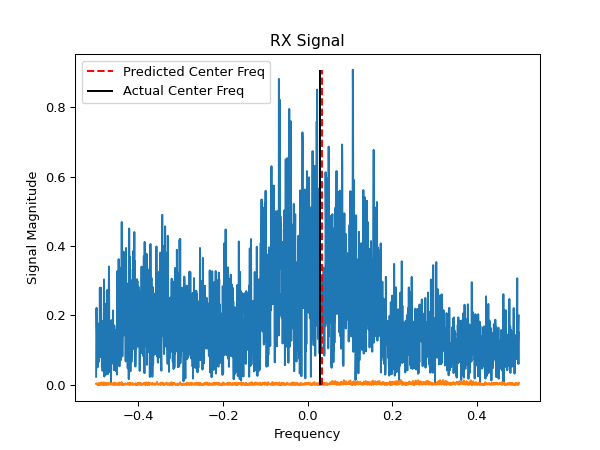

In [7]:
#Random integer input for checking random indices.
random_index = random.randint(0,len(testing_labels)-1)


predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()

#Table of NN Prediction vs the Actual Value
table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))

    
    
# Plot of testing data with an overlay of the predicted center frequency vs the actual center frequency.
# NOTE: Orange plot is from the untransformed time data from the beginning of the network and the Blue plot is the 
# fourier transformed frequency data.

plt.figure(1)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf1.svg", format = "svg")

                                 NN Prediction              Actual value
         Start Time:        0.6587870121002197             0.70263671875
          Stop Time:        0.9951448440551758               0.974609375
          Bandwidth:       0.42648792266845703         0.345236212015152
                SNR:        0.9504778385162354        0.9078889489173889
   Center Frequency:        0.1143319234251976       0.11169499903917313


<IPython.core.display.Javascript object>


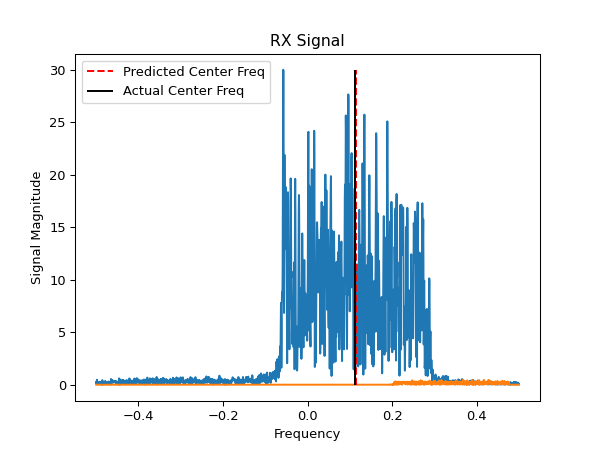

In [8]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

#print("Index value:", random_index)

predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()


table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))


plt.figure(2)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf2.svg", format = "svg")

                                 NN Prediction              Actual value
         Start Time:        0.3544074594974518             0.28564453125
          Stop Time:        0.9583874344825745                 0.9921875
          Bandwidth:        0.7633248567581177        0.7573335766792297
                SNR:        0.2594851851463318       0.23315595090389252
   Center Frequency:      -0.00553144421428442      0.006066999863833189


<IPython.core.display.Javascript object>


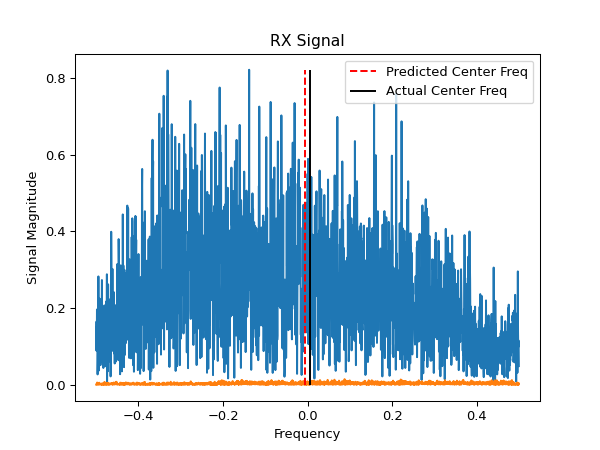

In [9]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

#print("Index value:", random_index)

predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()


table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))


plt.figure(3)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf3.svg", format = "svg")

                                 NN Prediction              Actual value
         Start Time:        0.6614783406257629                0.65234375
          Stop Time:        0.9811145067214966             0.95556640625
          Bandwidth:        0.2904649078845978       0.31469181180000305
                SNR:        0.2850511372089386        0.2621914744377136
   Center Frequency:       0.10288853198289871        0.0961351990699768


<IPython.core.display.Javascript object>


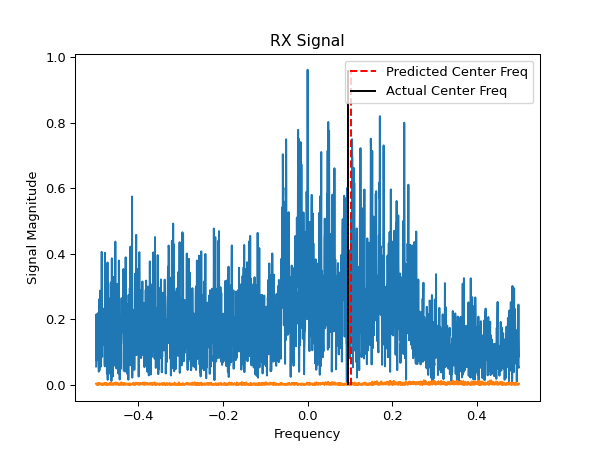

In [10]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

#print("Index value:", random_index)

predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()


table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))


plt.figure(4)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

#plt.savefig("cf4.svg", format = "svg")

                                 NN Prediction              Actual value
         Start Time:        0.3759085237979889             0.34326171875
          Stop Time:        0.5770314335823059             0.53857421875
          Bandwidth:       0.16488191485404968        0.1681537926197052
                SNR:        0.8183600902557373        0.8141606450080872
   Center Frequency:      0.016698919236660004      0.013104800134897232


<IPython.core.display.Javascript object>


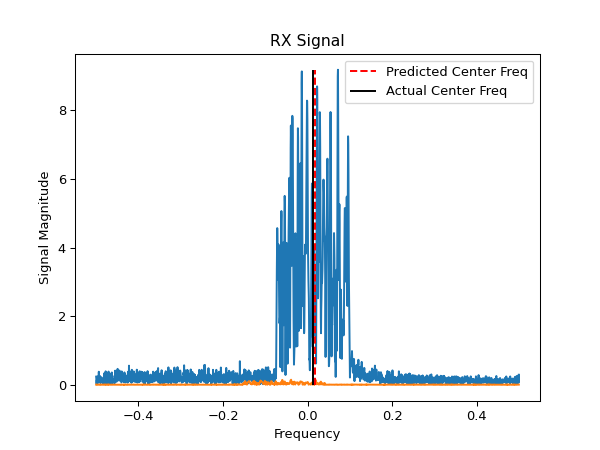

In [11]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

#print("Index value:", random_index)

predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()


table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))


plt.figure(5)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()



#plt.savefig("cf5.svg", format = "svg")

                                 NN Prediction              Actual value
         Start Time:       0.23991137742996216              0.1748046875
          Stop Time:        0.9705687761306763                0.97265625
          Bandwidth:        0.7225547432899475        0.7292590141296387
                SNR:        0.9445431232452393        0.9754850268363953
   Center Frequency:       -0.0179136972874403     -0.006495200097560883


<IPython.core.display.Javascript object>


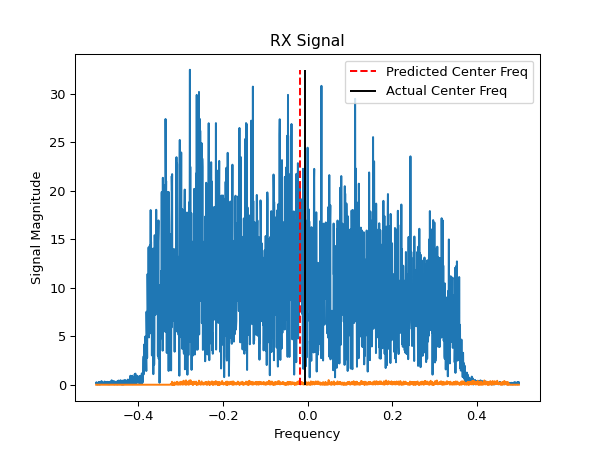

In [12]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

#print("Index value:", random_index)

predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()


table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))


plt.figure(6)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()



#plt.savefig("cf6.svg", format = "svg")

                                 NN Prediction              Actual value
         Start Time:        0.7168458104133606                0.72265625
          Stop Time:        0.9787407517433167                0.98828125
          Bandwidth:         0.430856853723526        0.4394434094429016
                SNR:         0.800638735294342        0.8050114512443542
   Center Frequency:      0.027949387207627296       0.03299739956855774


<IPython.core.display.Javascript object>


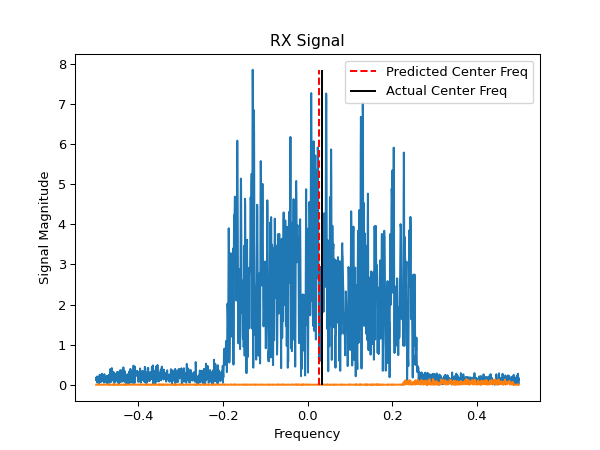

In [13]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

#print("Index value:", random_index)

predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()


table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))


plt.figure(7)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()



#plt.savefig("cf7.svg", format = "svg")

                                 NN Prediction              Actual value
         Start Time:        0.1642153263092041              0.1708984375
          Stop Time:         0.761522114276886                0.75390625
          Bandwidth:        0.8151333928108215        0.8072180151939392
                SNR:        0.9496343731880188        0.9215506911277771
   Center Frequency:     -0.029231829568743706     -0.010707800276577473


<IPython.core.display.Javascript object>


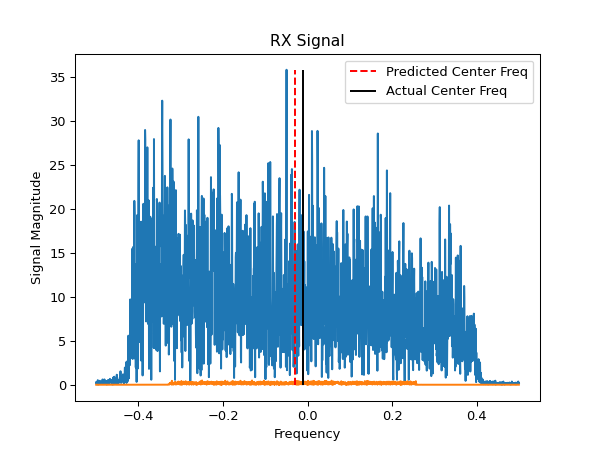

In [14]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

#print("Index value:", random_index)

predict_cf = model.predict(testing_data)


predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].numpy()


table_data = [
    ['', 'NN Prediction', 'Actual value'],
    ['Start Time:', predict_list[0], testing_list[0]],
    ['Stop Time:', predict_list[1], testing_list[1]],
    ['Bandwidth:', predict_list[2], testing_list[2]],
    ['SNR:', predict_list[3], testing_list[3]],
    ['Center Frequency:', predict_list[4], testing_list[4]],
]

for row in table_data:
    print("{: >20} {: >25} {:>25}".format(*row))


plt.figure(8)
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[4]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[4]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()



#plt.savefig("cf8.svg", format = "svg")

In [15]:
#model.save('Time_Freq_CNN.h5')


In [16]:
loss = model.evaluate(testing_data, batch_size=128)
print("test loss, test acc:", loss)
print(loss)
print(history_f.history)

#mean square
loss = history_f.history['loss']
val_loss = history_f.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss)
sqrt_val_loss = np.sqrt(val_loss)

# plt.loglog(sqrt_loss, 'r', label='Training Loss')
# plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

47/47 [==============================] - 0s 569us/step - loss: 0.0000e+00
test loss, test acc: 0.0
0.0
{'loss': [0.06035229563713074, 0.0235743448138237, 0.020375411957502365, 0.01847551204264164, 0.017038103193044662, 0.015687325969338417, 0.014534328132867813, 0.013654874637722969, 0.013031871058046818, 0.012520316988229752, 0.012098212726414204, 0.011717446148395538, 0.011366776190698147, 0.011045437306165695, 0.010749904438853264, 0.010457734577357769, 0.010212179273366928, 0.009980907663702965, 0.009759267792105675, 0.009549367241561413, 0.009381544776260853, 0.009201370179653168, 0.009042621590197086, 0.008903410285711288, 0.008763018995523453, 0.00863930769264698, 0.008517682552337646, 0.008393978700041771, 0.008308496326208115, 0.008198951371014118, 0.008119002915918827, 0.008015798404812813, 0.007932079955935478, 0.007853113114833832, 0.007765720132738352, 0.00769576383754611, 0.007623478304594755, 0.007563300430774689, 0.007482015527784824, 0.007417883723974228, 0.00735157495

<IPython.core.display.Javascript object>


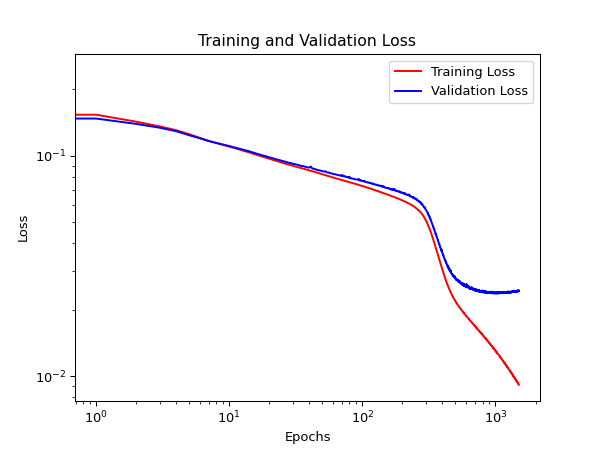

In [17]:
plt.figure(9)
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
#tf.config.list_physical_devices()